## Design

How to integrate ML to a Product with success?

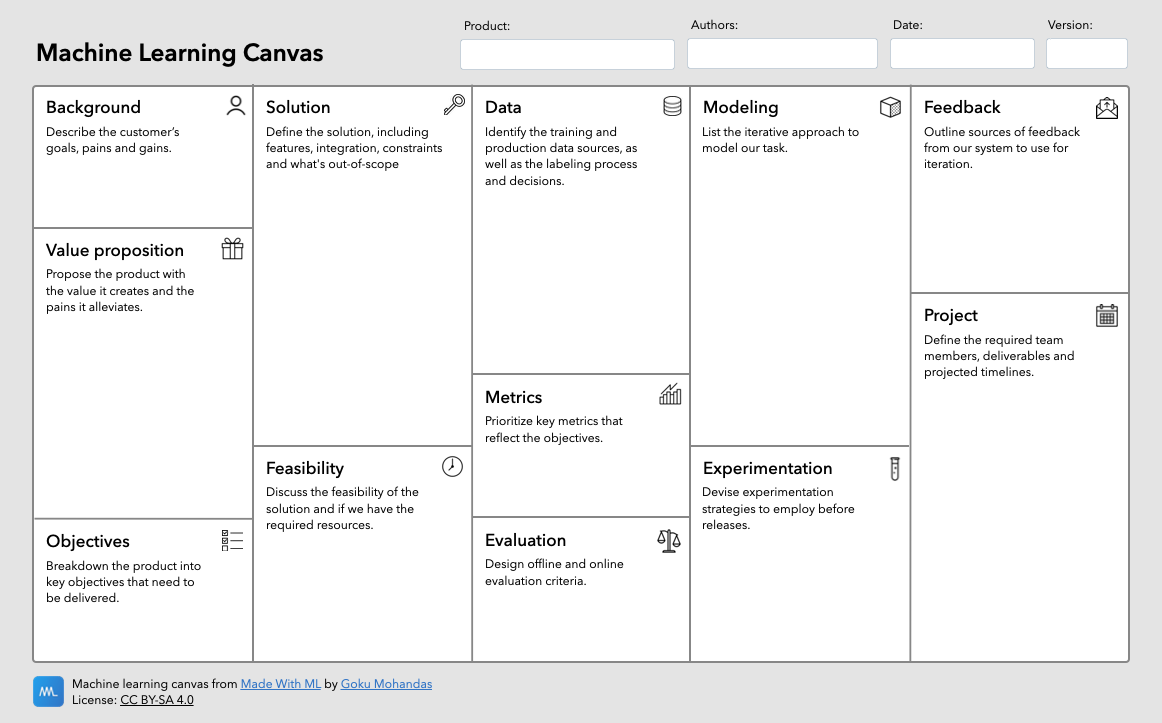

For each product release:
- Requirements
- Design docs
- Project planning

### Product

What and Why

- Background: customer (internal/external, existing/new), goal, pains/obstacles, gains
- Value proposition: product to build, alleviates which pains, create which gains
- Objectives: key goals to focus on
- Solution: core features, out of scope, alternatives, constraints (QA)
- Feasibility: data, team, money, time

### Engineering

How

- Data: training/production sources of data
- Labeling: ontology, features
- Evaluation: metrics, offline, online
- Modeling: end-to-end utility, manual/rule-based before ML, augment vs. automate, feedback/human-in-the-loop

### Project

Who & When

- Team involved 
- Deliverables: Description, contributors, AC
- Timeline

## Data

### Labeling

#### Workflow

- WHAT to label
   - natural existing labels (e.g. time-series)
   - domain expert validation of construct being measured
- WHERE to label
   - interface
   - consensus / discrepancies
- HOW to label
   - examples
   - how to solve ambiguous cases / discrepancies

Workflow

- Data pipelines
    - Import data for annotations
    - Export annotated data for QA, testing, modeling etc.
- QA workflow
- Iterative setup
    - active learning
    - weak supervision
    - long tail edge cases
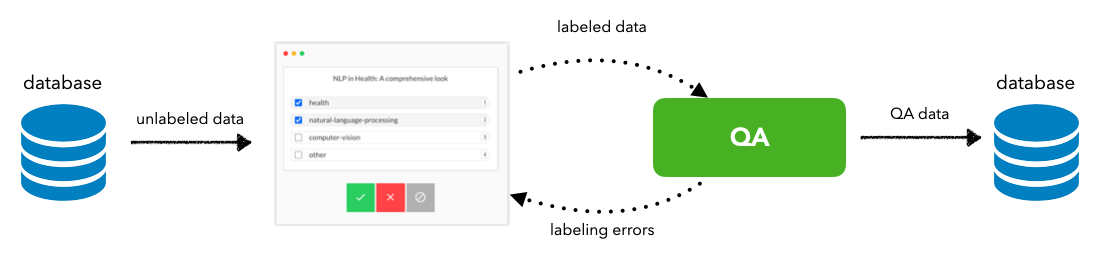

#### ETL for labeled data

Here data is already labeled

In [ ]:
# get data from git repo
!wget -O data/projects.csv https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.csv
!wget -O data/labels.csv https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.csv

In [10]:
import pandas as pd

In [13]:
projects = pd.read_csv("data/projects.csv")
tags = pd.read_csv("data/labels.csv")

In [14]:
projects.head(3)

,id,created_on,title,description
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla..."


In [15]:
tags.head(3)

,id,tag
0,6,computer-vision
1,7,computer-vision
2,9,graph-learning


In [18]:
df = pd.merge(projects, tags, on="id")
df = df[df.tag.notnull()]
df.to_csv("data/labeled_projects.csv", index=False)

**Labeling tools**
- LabelBox, Scale, LabeStudio, Prodigy Superintendent (ipywidgets)...
- NLP-specific: Doccano, BRAT

See [here](https://madewithml.com/courses/mlops/labeling/#general) for more labeling tools

**Active learning**
- Label small dataset to train model
- Use model to predict unlabeled data
- Find new data points based on:
    - entroopy of predicted class proba
    - samples with lowest confidence or calibration
    
See this [literature survey](https://burrsettles.com/pub/settles.activelearning.pdf) on active learning

Some libraries: [modAl](https://github.com/modAL-python/modAL), libact, AliPy

**Weak supervision**

- snorkel

### EDA

- Do we have required data for our tasks?
- Gain insights on what data look like, mainly via descriptive statistics

In [26]:
from collections import Counter
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS

In [4]:
df = pd.read_csv("data/labeled_projects.csv")

In [6]:
df.describe()

,id
count,955.000000
mean,1253.503665
std,715.636288
min,6.000000
25%,622.500000
50%,1236.000000
75%,1897.000000
max,2437.000000


In [24]:
df["id"] = df.id.fillna(df.id.mean())

1253.503664921466

In [ ]:
# normal distribution
df[np.abs(df.A - df.A.mean()) <= 2 * df.A.std()]

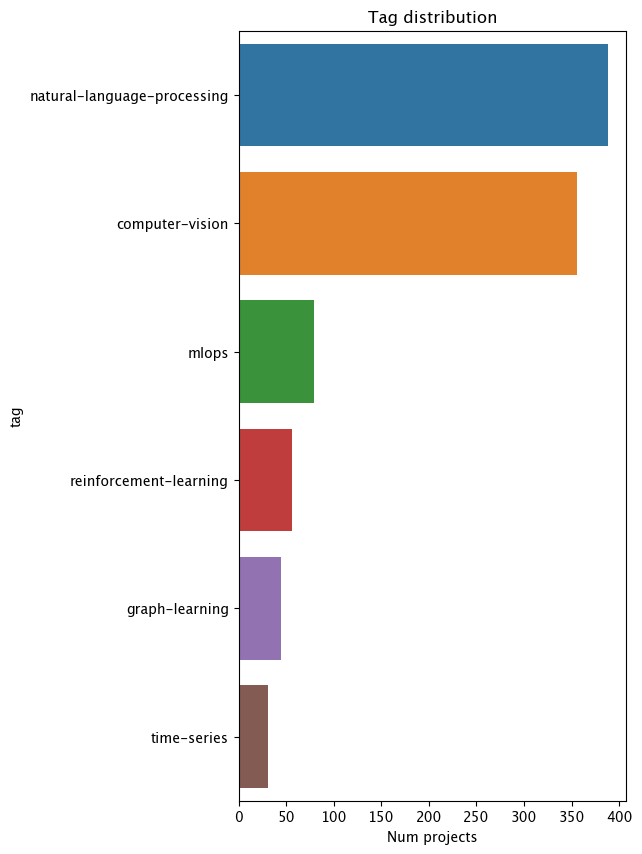

In [44]:
plt.figure(figsize=(5,10))
plt.title("Tag distribution")
ax = sns.countplot(data=df, y="tag", 
              order = df.tag.value_counts().index)
plt.xlabel("Num projects");

In [50]:
def display_word_cloud(tag="natural-language-processing"):
    # Plot word clouds top top tags
    plt.figure(figsize=(15, 5))
    subset = df[df.tag==tag]
    text = subset.title.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)

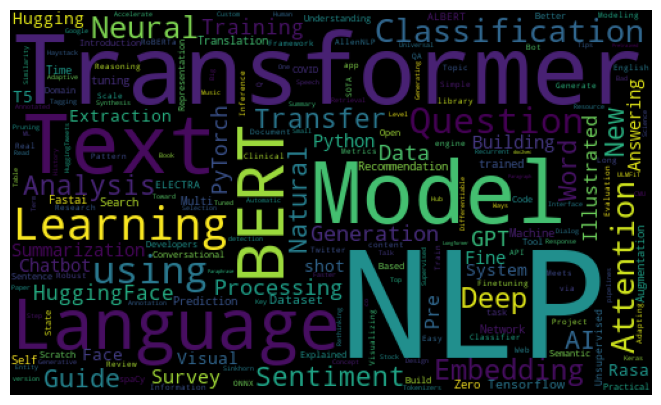

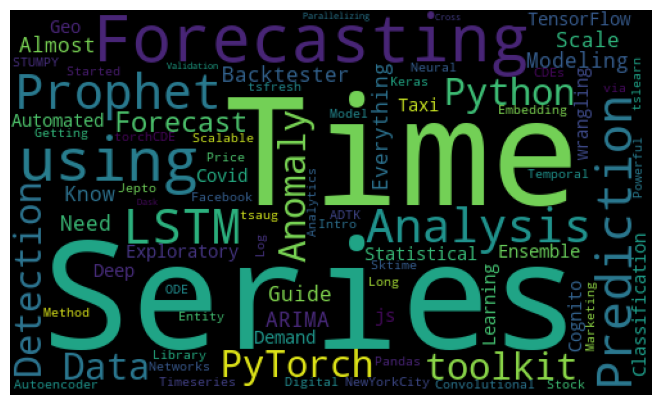

In [52]:
display_word_cloud(tag="natural-language-processing")
display_word_cloud(tag="time-series")

### Preprocessing

- Some steps are global, data-independent (lowercasing, stopwords etc.) while others are local (vocabulary, standardization etc.)
- Important to split train/test before applying local transformations (e.g. the vocabulary shoult be built from train only)

#### Preparing

Organize + Clean data

- Joins to get metadata and features. 
- Careful to have point-in-time joins so that same features in train and test

- Strategies for **missing values**
   - Ignore samples with missing values if rare
   - Ignore whole features if most values are NaN
   - Replace with heuristics (descriptive stats like mean of most frequent value Or from domain-expert rules)
   - Normalize between np.nan, "", None, -1 etc.
   
- Strategies for **outliers**
    - Define it. Classic definition being withing 2 std
    - Depend on the task, e.g. do outliers carry some useful signal like accident or fraud
    
- Cleaning: contraintss/filters, data type, normalization etc.

#### Transforming

- Scaling
    - linear models
    - learn constructs like vocabulary
    - standardize: normal, min/max, binning
- Encoding
    - Represent data features to maintain signal and reduce sparsity
- Extracting
    - Combine features
    - Project features using PCA, transfer learning, autoencoders etc.

#### Implementation

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import numpy as np

In [67]:
texts = df.title + " " + df.description
labels = df.tag.tolist()

In [87]:
base_pipeline = Pipeline(steps= [
    ("tfidf", TfidfVectorizer(lowercase=True)),
    ("svm", LinearSVC(class_weight="balanced"))])

scores = cross_val_score(base_pipeline, texts, labels)
print(f"{np.mean(scores)} +/- {np.std(scores)}")

0.8890052356020943 +/- 0.02078474684950703


In [88]:
char_pipeline = Pipeline(steps= [
    ("tfidf", TfidfVectorizer(lowercase=True, ngram_range=(1,2))),
    ("svm", LinearSVC(class_weight="balanced"))])

scores = cross_val_score(char_pipeline, texts, labels)
print(f"{np.mean(scores)} +/- {np.std(scores)}")

0.881675392670157 +/- 0.012211417580827848


In [93]:
base_pipeline.fit(texts, labels)
pred = base_pipeline.predict(texts)

In [99]:
print(classification_report(labels, pred))

                             precision    recall  f1-score   support

            computer-vision       1.00      1.00      1.00       356
             graph-learning       1.00      1.00      1.00        45
                      mlops       1.00      1.00      1.00        79
natural-language-processing       1.00      1.00      1.00       388
     reinforcement-learning       1.00      1.00      1.00        56
                time-series       1.00      1.00      1.00        31

                   accuracy                           1.00       955
                  macro avg       1.00      1.00      1.00       955
               weighted avg       1.00      1.00      1.00       955



### Data Augmentation

- For training dataset
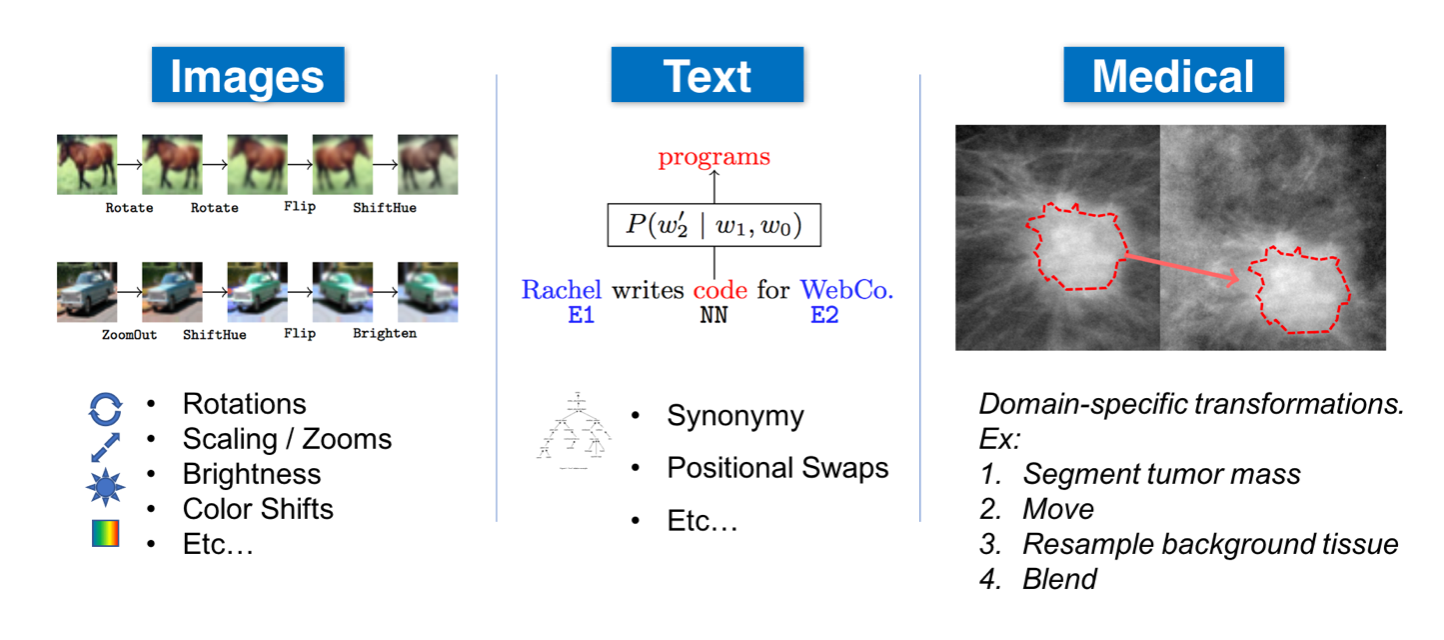
- For texts quite tricky since harder to inspect/validate
    - [NLPAug](https://github.com/makcedward/nlpaug/blob/master/example/textual_augmenter.ipynb)
    - [TextAttack](https://github.com/QData/TextAttack#augmentation-python-interface) -> perturb input to decrease model performance

- Warning: data augmentation needs to be done carefully so that the generated samples make sense, are useful for model performance, do not break existing data validation constraints
- Seems useful for classes with less data and where we can set clear heuristics for generating new samples, like specific synonyms or variations on numerical values etc.


## Modeling

### Baselines

- Start with simple baseline (random)
- Develop rule-based approach
- Add complexity to solve limitations
- Clearly state non-goals (e.g. performance, latency)
- Do not forget to iterate on data as well: cleaning - relabeling - features etc.

#### Distributed training
2 types:
- data parallelism: synchronous training (i.e. gradients are aggregated at the end of each batch) OR async training (independent)
- model parallelism: harder for backpropagation
- tools
    - [pytorch data parallelism](https://pytorch.org/tutorials/beginner/ddp_series_intro.html)
    - [ray-train](https://docs.ray.io/en/latest/train/train.html#)
    - [horovod](https://horovod.ai/)

#### Optimization
Use-case: model too large for deployment. Idea: compress model
- Pruning: remove weights i.e. increase model sparsity
- Quantization: reduce weight precision (e.g. 32b to 8b)
- Distillation: train smaller network to copy bigger network (harder)
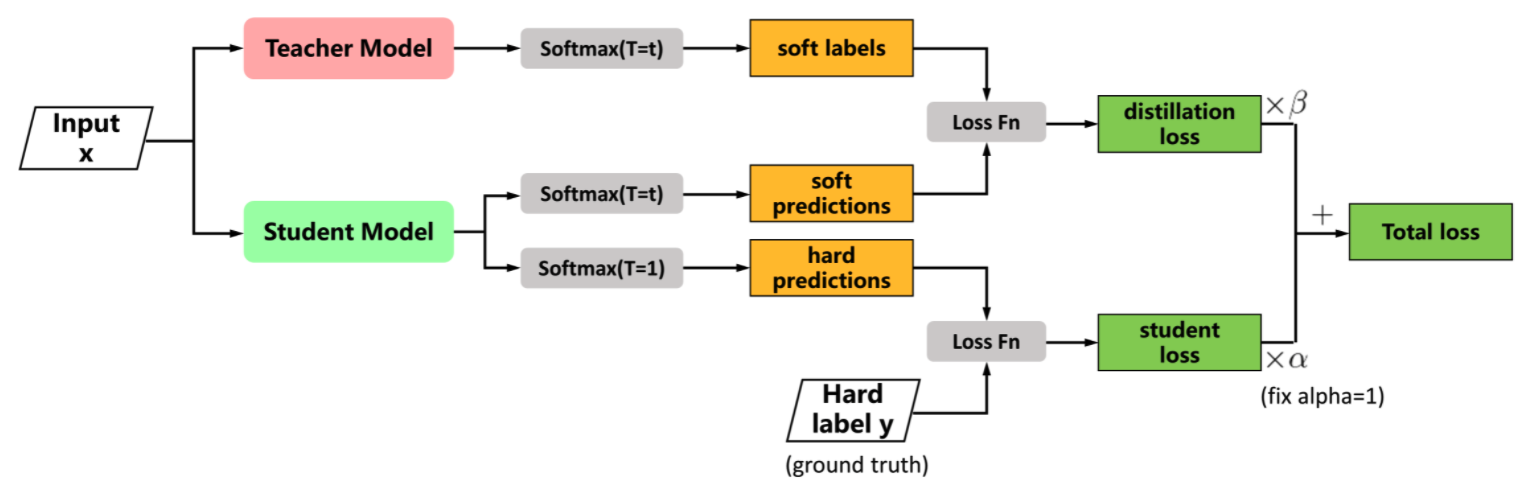

#### Baselines

- Random
- Rule-based
- Simple ML

In [114]:
from utils import get_data_splits, set_seeds, preprocess
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arthur/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [103]:
df = pd.read_csv("data/labeled_projects.csv")

In [122]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder

In [137]:
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=40)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.transform(df.tag))

In [125]:
y_pred = np.random.randint(low=0, high= label_encoder, size=len(y_test))

TypeError: object of type 'LabelEncoder' has no len()

In [126]:
from pathlib import Path

In [135]:
Path(Path.cwd().parent, "foundations")

PosixPath('/Users/arthur/Documents/code/courses/mlops-course/foundations')

In [138]:
df

,id,created_on,title,description,tag,text
0,437,2020-04-10 17:14:11,Pruning Bert to Accelerate Inference,After previously discussing various ways of ac...,natural-language-processing,pruning bert accelerate inference previously d...
1,1847,2020-07-13 03:46:32,Driver Identification Based on Vehicle's telem...,"In this paper, we proposed a deep learning mod...",computer-vision,driver identification based vehicle telematics...
2,1767,2020-07-11 05:05:31,Imagenette,Imagenette is a subset of 10 easily classified...,computer-vision,imagenette imagenette subset 10 easily classif...
3,858,2020-05-14 14:35:37,Open-Dialog Chatbots for Learning New Languages,A tutorial for automatically generate code com...,natural-language-processing,open dialog chatbots learning new languages tu...
4,1506,2020-06-19 06:26:17,Using GitHub Actions for MLOps & Data Science,A collection of resources on how to facilitate...,mlops,using github actions mlops data science collec...
...,...,...,...,...,...,...
950,2202,2020-08-22 03:55:27,Graph Representation Learning Book,"Introduction to graph representation learning,...",graph-learning,graph representation learning book introductio...
951,1585,2020-06-24 03:18:20,Breaking the cycle—Colleagues are all you need,A novel approach to performing image-to-image ...,computer-vision,breaking cycle colleagues need novel approach ...
952,2223,2020-08-26 04:21:37,AxCell,Automatic Extraction of Results from Machine L...,computer-vision,axcell automatic extraction results machine le...
953,2106,2020-08-08 15:06:18,Fast NST for Videos (+ person segmentation) 🎥 ...,Create NST videos and pick separate styles for...,computer-vision,fast nst videos person segmentation create nst...


In [ ]:
# Interesting idea to set threshold on predict_proba to pick a given class:
# -> Use mean value of Q1 from proba predictions per class

y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)
class_thresholds = {}
for index in range(len(label_encoder.classes)):
    class_thresholds[index] = np.mean(
        [y_prob[i][index] for i in np.where(y_pred==index)[0]])

## Evaluation

3 main evaluation types:
- overall
- per-class
- per slice

**Coarse-grained analysis**

- `precision_recall_fscore_support` with average = None to get metrics per class (similar to classification report)
- Confusion matrix

**Fine-grained analysis**

Idea - Identify mislabeled samples based on model confidence

- Calibration
  - We expect that the probability of a predicted class label ~ true likelihood of the label
  - But NN/complex models are over-confident, e.g. proba of main class label around 0.8/0.9
  - So use some temperature scaling for calibration

 - Platt scaling
   -  Fit LR on classifier scores (not probabilities)

- Labeling issues: cleanlab on OOS data (e.g. from KFold cross-validation)
  - Identify labels with lowest proba predictions, which can be wrong labeling
  - Ex: https://docs.cleanlab.ai/stable/tutorials/text.html

- Slices
  - Per-class or combinations of classes
  - Features or combinations of features
  - metadata
  - snorkel slices can be a nice util for masking/creating slices: https://www.snorkel.org/use-cases/03-spam-data-slicing-tutorial
  - Some tools are being developed for automated slicing

### Interpretability